In [ ]:
#!pip install --user patchify

#!pip install --user segmentation_models

In [1]:
import h5py
import os
import numpy as np
import io
import matplotlib.pyplot as plt  

from os import listdir
from os.path import isfile, join
from PIL import Image

In [2]:
import cv2
from patchify import patchify
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'TrainData'

patch_size = 128


2022-05-06 13:52:36.231072: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


## create the datasets

In [ ]:
def __geth5__(path):
    hf = h5py.File(path, 'r') # open a hdf5 file

    key = list(hf.keys())[0]
    #print("Keys: %s" %key)

    dataset = hf[key]
    #print(dataset.shape)
    
    #print(dataset)
    data = np.array(dataset)
    #print(bands[:,:,13])
    
    hf.close()  # close the hdf5 file
        
    return data
    

In [ ]:
image_dataset = []  
mask_dataset = []  

mypath = "/p/home/jusers/yao1/juwels/ai4eo/yao/7/TrainData/img"

for f in listdir(mypath):
    hdf5_file = os.path.join(mypath, f)
    
    # mask
    img_path = hdf5_file
    mask_path = img_path.replace('img', 'mask').replace('image', 'mask')
    
    image = __geth5__(img_path)
    mask = __geth5__(mask_path)
    
    image_dataset.append(image)
    mask_dataset.append(mask)
    
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
    

## save the datasets

In [ ]:
import pickle4reducer
import multiprocessing as mp
import pickle
ctx = mp.get_context()
ctx.reducer = pickle4reducer.Pickle4Reducer()

with mp.Pool(4) as p:
    pickle.dump(image_dataset, open("image_dataset.csv", 'wb'), protocol=4)
    pickle.dump(mask_dataset, open("mask_dataset.csv", 'wb'), protocol=4)


## load the datasets

In [3]:
import pickle4reducer
import multiprocessing as mp
import pickle

ctx = mp.get_context()
ctx.reducer = pickle4reducer.Pickle4Reducer()

with mp.Pool(4) as p:
    file = open("image_dataset.csv",'rb')
    image_dataset = pickle.load(file)
    file = open("mask_dataset.csv",'rb')
    mask_dataset = pickle.load(file)
    

In [4]:
import sys
import numpy
# print the maximum size of array
numpy.set_printoptions(threshold=sys.maxsize)

#mask: 1 is landslide, 0:no


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


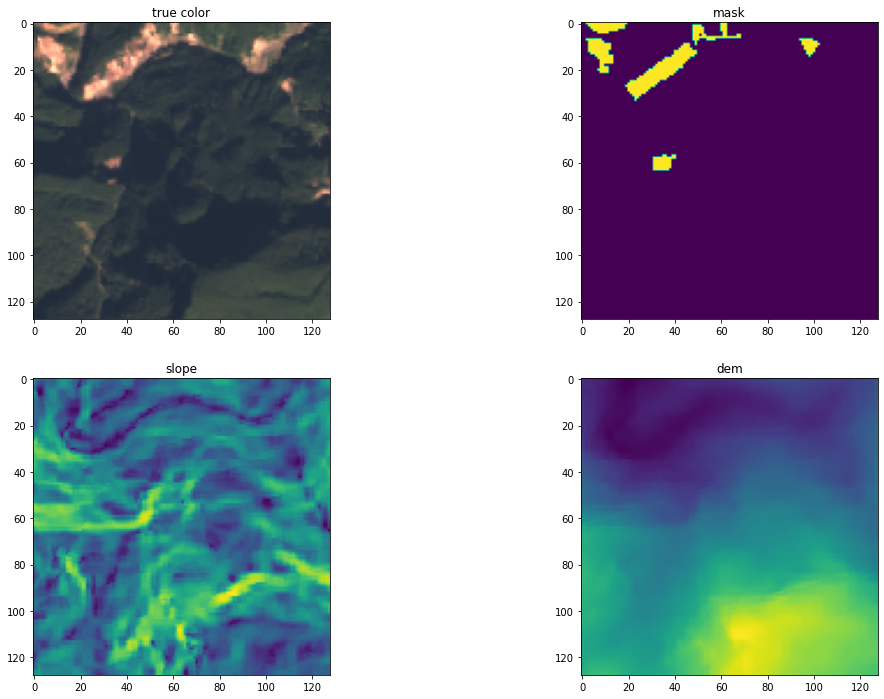

In [15]:
#Sanity check, view few mages
import random
image_number = random.randint(0, len(image_dataset))

image =np.reshape(image_dataset[image_number], (patch_size, patch_size, 14))
#print(image.shape)

# true color rgb
image_rgb = np.zeros((128, 128, 3))
image_rgb[:,:,0] = image[:, :, 3]/3
image_rgb[:,:,1] = image[:, :, 2]/3
image_rgb[:,:,2] = image[:, :, 1]/3

# Slope
image_slope = image[:,:,12]
# DEM
image_dem = image[:,:,13]
# mask
image_mask = np.reshape(mask_dataset[image_number], (patch_size, patch_size))

plt.figure(figsize=(18, 12))
plt.subplot(221)
plt.imshow(image_rgb)
plt.title('true color')
plt.subplot(222)
plt.imshow(image_mask)
plt.title('mask')
plt.subplot(223)
plt.imshow(image_slope)
plt.title('slope')
plt.subplot(224)
plt.imshow(image_dem)
plt.title('dem')
plt.show()


In [6]:
import tensorflow as tf
n_classes = 2

labels_pos = np.float32(mask_dataset)

labels_neg = np.abs(labels_pos - 1)

labels_cat = np.zeros((3799, 128, 128, 2))

labels_cat[:,:,:,0] = labels_pos
labels_cat[:,:,:,1] = labels_neg

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


## still need to test

In [ ]:
# set up for multiple gpus
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()

# Choose which device you want to test on: either 'cpu' or 'gpu'
devices = ['gpu']

print('number of device:...'.format(strategy.num_replicas_in_sync))

!nvidia-smi

## distributed training

In [ ]:
import horovod.tensorflow.keras as hvd

# Horovod: initialize Horovod.
hvd.init()

# Horovod: pin GPU to be used to process local rank (one GPU per process)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        

## not working yet

In [7]:

weights = [0.2, 0.8]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from simple_multi_unet_model import jacard_coef, multi_unet_model

metrics = ["accuracy", jacard_coef]

In [ ]:

def get_model():
    return multi_unet_model(
        n_classes=n_classes,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS,
    )


model = get_model()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(
    X_train,
    y_train,
    batch_size=16,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False,
)

In [ ]:
# save the model
model.save('models/single_unet_100epochs_14April2022.hdf5')


In [16]:

from keras.models import load_model


model = load_model("models/single_unet_100epochs_14April2022.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                    'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.7789313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


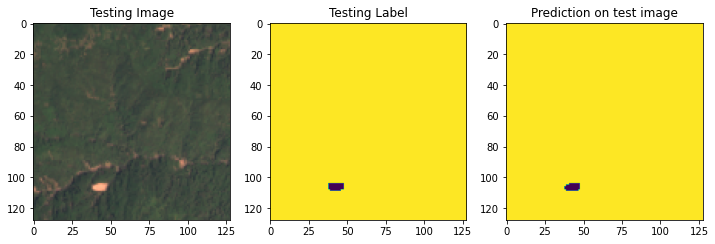

In [17]:
#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

# true color rgb
image_rgb = np.zeros((128, 128, 3))
image_rgb[:,:,0] = test_img[:, :, 3]/3
image_rgb[:,:,1] = test_img[:, :, 2]/3
image_rgb[:,:,2] = test_img[:, :, 1]/3

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image_rgb)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################